# Setting up the data for classification

The following code chunk is from Kaggle to get the images as vectors, I added the paths to the project data on my machine and 3 lines of code combining all of the images and then doing a train test split.

shape: (120, 180)
min: 13 max: 179
dtype: uint8


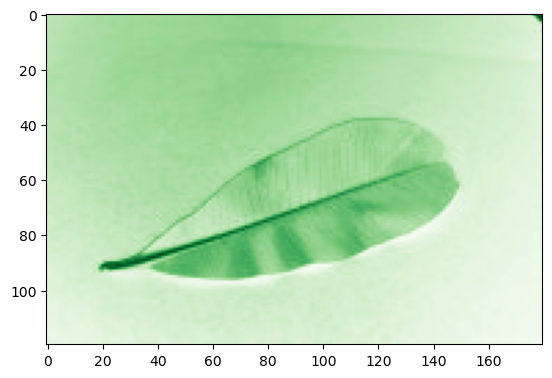

../Machine Learning/CS3540-final-project/Project Data/train/train
shape of X: (4274, 21600)
dtype: float64
shape of y: (4274,)
../Machine Learning/CS3540-final-project/Project Data/valid/valid
shape of X: (110, 21600)
dtype: float64
shape of y: (110,)
../Machine Learning/CS3540-final-project/Project Data/test/test
shape of X: (110, 21600)
dtype: float64
shape of y: (110,)


In [13]:
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split


def format_image(path):
    """Takes a path to an image as input. Returns a numpy array representing the green channel of the image."""
    # Load the image using PIL
    pillow_img = Image.open(path)
    img = np.array(pillow_img)
    return(img[:,:,1] ) # green channel

# Test the function on an example image 
path = "../Machine Learning/CS3540-final-project/Project Data/train/train/Alstonia Scholaris/0003_0011.JPG"    
img = format_image(path)
print('shape:', img.shape) # (120, 180)
print('min:', img.min(), 'max:', img.max()) # min: 0 max: 255
print('dtype:', img.dtype) # uint8

%matplotlib inline
import matplotlib.pyplot as plt

# Plot the Green channel
plt.imshow(img, cmap=plt.cm.Greens) # Greens colormap
plt.show()

from os import listdir
from os.path import isfile, join
from PIL import Image
import numpy as np

# path to the training set
TRAIN_PATH = "../Machine Learning/CS3540-final-project/Project Data/train/train"
# path to the validation set
VALID_PATH = "../Machine Learning/CS3540-final-project/Project Data/valid/valid"
# path to the test set
TEST_PATH = "../Machine Learning/CS3540-final-project/Project Data/test/test"

def make_matrix_from_dir(path):
    """Takes a dir as argumen and returns two numpy arrays: features and labels"""
    # the feature matrix and labels list
    features = []  # the pixel data
    labels = []  # the image labels (species)

    # get a list of all images in the dataset
    species_in_dataset = listdir(path)
    for species in species_in_dataset:
        if species == ".DS_Store":  # Skip .DS_Store file
            continue
        species_path = join(path, species)
        file_paths = [f for f in listdir(species_path) if isfile(join(species_path, f))]
        # load the images
        for file_path in file_paths:
            # load image, convert to numpy array with 3 channels: RGB
            # flatten the image to a 1-dimensional array,
            flat_img = format_image(join(species_path, file_path)).flatten()
            features.append(flat_img)
            labels.append(species)

    # format the features array to a vector of dimensions (num_images, num_pixels_in_each_image)
    X = np.array(features)
    # convert features to floats (as expected by scikit-learn)
    X = X.astype(float)
    # pack labels in numpy array
    y = np.array(labels)
    return X, y

X_train, y_train = make_matrix_from_dir(TRAIN_PATH)
X_valid, y_valid = make_matrix_from_dir(VALID_PATH)
X_test, y_test = make_matrix_from_dir(TEST_PATH)

# MY CODE
X_all = np.concatenate([X_train, X_valid, X_test], axis=0)
y_all = np.concatenate([y_train, y_valid, y_test], axis=0)
X_not_test = np.concatenate([X_train, X_valid], axis=0)
y_not_test = np.concatenate([y_train, y_valid], axis=0)
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)
# END OF MY CODE

def print_info(path, X, y):
    """Print feedback on features/labels matrices"""
    # print path to data dir
    print(path)
    # Print shape
    print('shape of X:', X.shape) # (num_images, num_pixels_in_each_image)
    # Print data type
    print('dtype:', X.dtype) # float64
    print('shape of y:', y.shape) # (num_images)
    
print_info(TRAIN_PATH, X_train, y_train)
print_info(VALID_PATH, X_valid, y_valid)
print_info(TEST_PATH, X_test, y_test)

# PCA and K-Means

For PCA and K-means, the idea is to run PCA on the images, take some K components and do k means with N clusters. From there, assign each cluster with a label from the majority of that cluster and then compute accuracy using the test data. This is a k-means/nearest neighbor experiment that is meant to test the hypothesis that the same species of leaves will cluster based on principle components.

The following code chunk uses PCA like we did in HW4 and then applies components necessary for 90% energy to do K-means on 12 clusters (the number of labels). This is the baseline for this methodology. 

In [18]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# set seed for reproducability
np.random.seed(42)

# encoding the labels to not have to deal with text until later
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit(y_all)
y_train_encoded = label_encoder.transform(y_new_train)
y_test_encoded = label_encoder.transform(y_new_test)

# # HW4 steps: 
# instead of detrend, normalize with StandardScaler, found this works better 
scaler = StandardScaler()
X_train1 = scaler.fit_transform(X_new_train)
X_test1 = scaler.transform(X_new_test)

# SVD
U, sigma, Vt = np.linalg.svd(X_train1, full_matrices=False)
# hw4 calc of the energy
total_energy = np.sum(sigma)

energy_percent = 0
i = 0
energy = 0
while energy_percent < 0.9:
    energy += sigma[i]
    energy_percent = energy / total_energy
    i += 1

# print the number of components for 90% energy to try above
print(f"Number of components needed for 90% energy: {i}")
# k components on the detrended values, using 2241 from 90% energy calc 
k = 2241
X_train_pca = X_train1 @ Vt.T[:, :k]

# test data
X_test_pca = X_test1 @ Vt.T[:, :k]

# k means on n clusters with the pca data
n_clusters = len(np.unique(y_train_encoded))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)

# take the majority and label the cluster that species
cluster_to_label = {}
for cluster in range(n_clusters):
    indices = np.where(train_clusters == cluster)[0]
    if len(indices) != 0:
        majority_label = np.bincount(y_train_encoded[indices]).argmax()
        cluster_to_label[cluster] = majority_label

# predict the cluster and therefore the label
test_clusters = kmeans.predict(X_test_pca)
test_labels = np.array([cluster_to_label.get(cluster) for cluster in test_clusters])

# accuracy calc 
accuracy = accuracy_score(y_test_encoded, test_labels)
print(f"Test accuracy for k = 2241 (90% energy): {accuracy:.4f}")
message = """This seems like way to many components but I wanted to do a baseline of 90% energy and n components = 12 aka the number of species labels. Next I will do a search of values of K and N to find optimal values."""
print(message)


Number of components needed for 90% energy: 2241
Test accuracy for k = 2241 (90% energy): 0.4549
This seems like way to many components but I wanted to do a baseline of 90% energy and n components = 12 aka the number of species labels. Next I will do a search of values of K and N to find optimal values.


In [20]:
# testing different values of N
k_list = [30]
n_list = list(range(50, 1000, 50))
best_accuracy = 0
best_k = None
best_n = None
accs = []
# loop through k 
for k in k_list:
    X_train_pca = X_train1 @ Vt.T[:, :k]
    X_test_pca = X_test1@ Vt.T[:, :k]

    # loop through n
    for n_clusters in n_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        train_clusters = kmeans.fit_predict(X_train_pca)

        # same method as above
        cluster_to_label = {}
        for cluster in range(n_clusters):
            indices = np.where(train_clusters == cluster)[0]
            if len(indices) != 0:
                majority_label = np.bincount(y_train_encoded[indices]).argmax()
                cluster_to_label[cluster] = majority_label

        # predict the cluster and therefore the label
        test_clusters = kmeans.predict(X_test_pca)
        test_labels = np.array([cluster_to_label.get(cluster) for cluster in test_clusters])

        # accuracy
        acc = accuracy_score(y_test_encoded, test_labels)
        accs.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_k = k
            best_n = n_clusters

print(f"Best Accuracy using a search of k = 30 and different n: {best_accuracy:.4f} with {best_k} PCA components and {best_n} clusters.")

Best Accuracy using a search of k = 30 and different n: 0.7675 with 30 PCA components and 900 clusters.


We see that accuracy levels out at about 200 clusters 


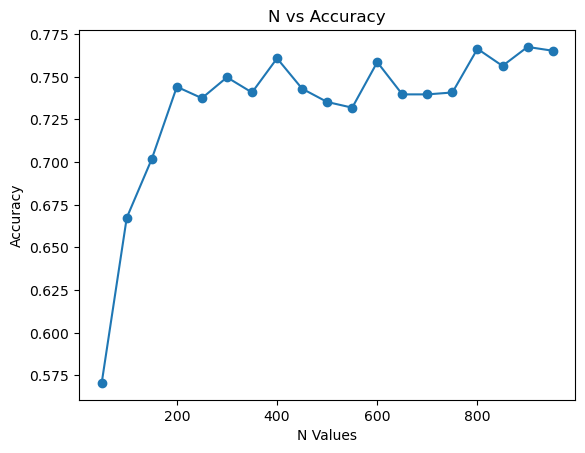

In [22]:
plt.plot(n_list, accs, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('N Values')
plt.ylabel('Accuracy')
plt.title('N vs Accuracy')

message2 = """We see that accuracy levels out at about 200 clusters """
print(message2)

After plotting N values, we see that the accuracy levels out at about 200 and for simplicity for generalizable models, I will use 200 clusters. The next chunk uses esentially the same code to look through different values for K components.

In [25]:
k_list = list(range(10, 101, 10))
n_list = [200]
best_accuracy = 0
best_k = None
best_n = None
accs = []
# loop through k 
for k in k_list:
    X_train_pca = X_train1 @ Vt.T[:, :k]
    X_test_pca = X_test1 @ Vt.T[:, :k]

    # loop through n
    for n_clusters in n_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        train_clusters = kmeans.fit_predict(X_train_pca)

        # same method as above
        cluster_to_label = {}
        for cluster in range(n_clusters):
            indices = np.where(train_clusters == cluster)[0]
            if len(indices) != 0:
                majority_label = np.bincount(y_train_encoded[indices]).argmax()
                cluster_to_label[cluster] = majority_label

        # predict the cluster and therefore the label
        test_clusters = kmeans.predict(X_test_pca)
        test_labels = np.array([cluster_to_label.get(cluster) for cluster in test_clusters])

        # accuracy
        acc = accuracy_score(y_test_encoded, test_labels)
        accs.append(acc)
        if acc > best_accuracy:
            best_accuracy = acc
            best_k = k
            best_n = n_clusters

print(f"Best Accuracy using a search of different k and n = 200: {best_accuracy:.4f} with {best_k} PCA components and {best_n} clusters.")


Best Accuracy using a search of different k and n = 200: 0.7442 with 30 PCA components and 200 clusters.


We see that accuracy peaks at 30 components and really moves up and down


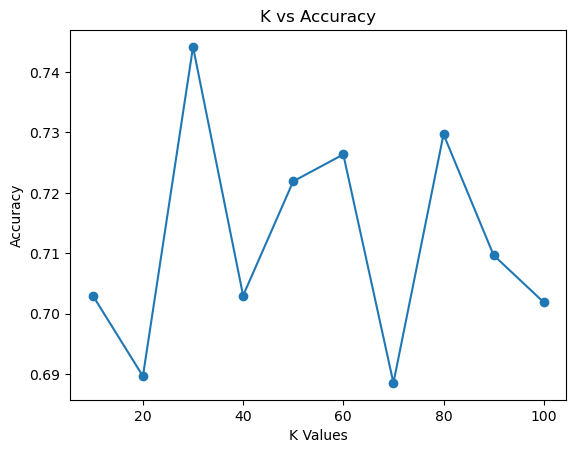

In [27]:
plt.plot(k_list, accs, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('K vs Accuracy')

message2 = """We see that accuracy peaks at 30 components and really moves up and down"""
print(message2)

I will use 30 components because that is significantly better than 10 or 20 and less complex (and better accuracy in this case) than larger values. The next code chunk runs the PCA and K-means classification with k = 30 and n = 200 and plots a confusion matrix 

Accuracy using optimal values: 0.7442 with 30 PCA components and 200 clusters.


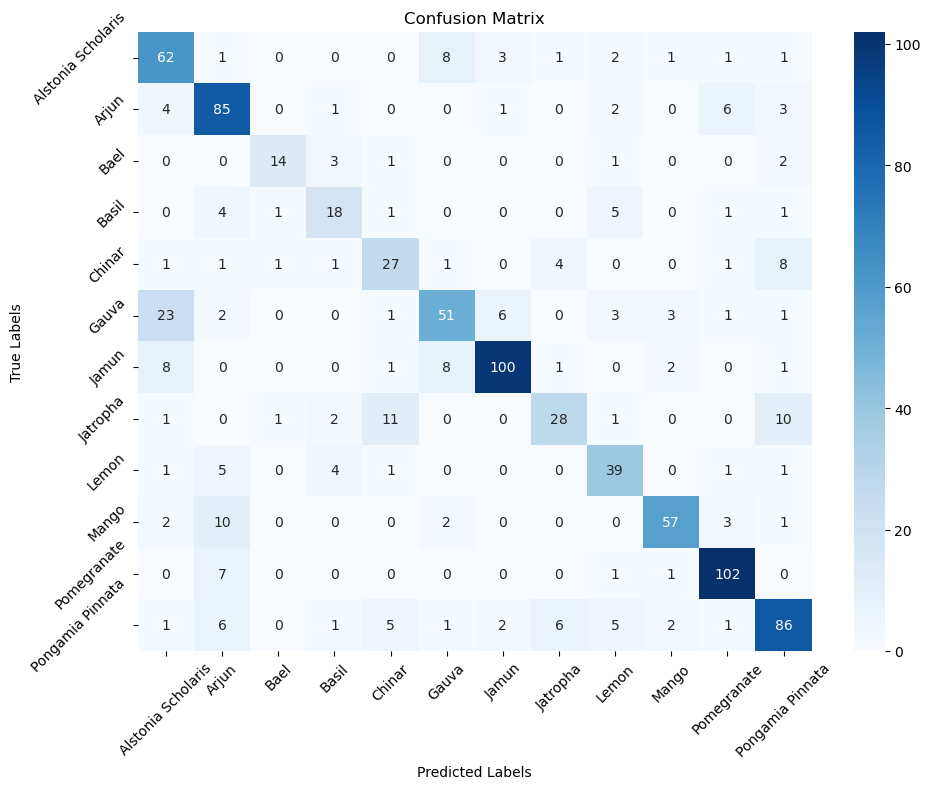

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = label_encoder.classes_ 

# plot confusion matrix for optimal values from the grid search
# same method as above
X_train_pca = X_train1 @ Vt.T[:, :30]
X_test_pca = X_test1 @ Vt.T[:, :30]
kmeans = KMeans(n_clusters=200, random_state=42)
train_clusters = kmeans.fit_predict(X_train_pca)
cluster_to_label = {}
cluster_species_count = {}
for cluster in range(200):
    indices = np.where(train_clusters == cluster)[0]
    num_points = len(indices)
    if len(indices) != 0:
        species_counts = np.bincount(y_train_encoded[indices], minlength=len(class_names))
        cluster_species_count[cluster] = species_counts
        majority_label = np.bincount(y_train_encoded[indices]).argmax()
        cluster_to_label[cluster] = majority_label
test_clusters = kmeans.predict(X_test_pca)
test_labels = np.array([cluster_to_label.get(cluster) for cluster in test_clusters])

acc = accuracy_score(y_test_encoded, test_labels)
print(f"Accuracy using optimal values: {acc:.4f} with 30 PCA components and 200 clusters.")

# plot the confusion matrix
cm = confusion_matrix(y_test_encoded, test_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


We get an accuracy of 0.7442 and a decent looking confusion matrix yet this is still worse than most other methodologies.

In [33]:
from sklearn.model_selection import StratifiedKFold

np.random.seed(42)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_not_test)  

# 5 folds
k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X_not_test, y_encoded):
    # split with the k folds
    K_X_train, K_X_test = X_not_test[train_index], X_not_test[test_index]
    K_y_train, K_y_test = y_encoded[train_index], y_encoded[test_index]

    # same method
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(K_X_train)
    X_test_scaled = scaler.transform(K_X_test)
    U, sigma, Vt = np.linalg.svd(X_train_scaled, full_matrices=False)
    total_energy = np.sum(sigma)
    X_train_pca = X_train_scaled @ Vt.T[:, :30]
    X_test_pca = X_test_scaled @ Vt.T[:, :30]
    n_clusters = 200
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train_clusters = kmeans.fit_predict(X_train_pca)
    cluster_to_label = {}
    for cluster in range(n_clusters):
        indices = np.where(train_clusters == cluster)[0]
        if len(indices) > 0:
            majority_label = np.bincount(K_y_train[indices]).argmax()
            cluster_to_label[cluster] = majority_label
    test_clusters = kmeans.predict(X_test_pca)
    test_labels = np.array([cluster_to_label.get(cluster) for cluster in test_clusters]) 


    # calc acc
    accuracy = accuracy_score(K_y_test, test_labels)
    accuracies.append(accuracy)

# print k folds avg acc 
average_accuracy = np.mean(accuracies)
print(f"Average K-Fold Accuracy over {k_folds} folds: {average_accuracy:.4f}")


Average K-Fold Accuracy over 5 folds: 0.7071


# SVM

**The following 4 chunks are from kaggle**
This code will act as the baseline for SVM methods.

In [36]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# Create SVM
svc = SVC(kernel='rbf', C=1, gamma='scale')

pipe_svc = Pipeline([
    # ('scaler', StandardScaler()), # More accurate with standardization?
    ('scaler', None), # Better performance (faster) without standardization?
    ('svc', svc)
])

In [45]:
%%time
from sklearn.model_selection import GridSearchCV

# Create cross-validation object
grid_svc = {
    'svc__C': [1, 10, 100, 1000],
}
# create grid search with cross validation
gridsearch_svc = GridSearchCV(pipe_svc, grid_svc, cv=4, return_train_score=True, verbose=3, n_jobs=4)

# Fit estimator
gridsearch_svc.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
CPU times: user 1min 31s, sys: 1.62 s, total: 1min 32s
Wall time: 17min 29s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('scaler', None), ('svc', SVC(C=1))]),
             n_jobs=4, param_grid={'svc__C': [1, 10, 100, 1000]},
             return_train_score=True, verbose=3)

In [46]:
import pandas as pd

# Collect results in a DataFrame
results_svc = pd.DataFrame(gridsearch_svc.cv_results_)

# Print a few interesting columns
cols = ['mean_test_score', 'std_test_score', 'mean_train_score', 'std_train_score', 'param_svc__C']
sorted_svc = results_svc[cols].sort_values('mean_test_score', ascending=False)
sorted_svc.head(10)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_svc__C
2,0.843937,0.012294,0.999922,0.000135,100
3,0.843703,0.012325,1.000000,0.000000,1000
1,0.843234,0.015112,0.995399,0.001089,10
0,0.788720,0.008636,0.883169,0.004817,1


In [47]:
# get best parameter from result of grid search
C = sorted_svc.iloc[0]['param_svc__C']

# set parameter in pipeline
pipe_svc.set_params(svc__C=C)

# fit the model
pipe_svc.fit(X_train, y_train)

# compute accuracy on test dataset
acc_test_svc = pipe_svc.score(X_test, y_test)
acc_test_svc

0.8363636363636363

**End of Kaggle code**
The next couple chunks I try a couple methods to improve the SVM architecture

Use standardscaler

In [50]:
from sklearn.preprocessing import StandardScaler

# Pipeline WITH scaling
pipe_svc_scaled = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(C=100, gamma='scale', kernel='rbf'))
])

# Fit and evaluate
pipe_svc_scaled.fit(X_train, y_train)
acc_scaled = pipe_svc_scaled.score(X_test, y_test)

print(f"Test Accuracy with StandardScaler: {acc_scaled:.4f}")

Test Accuracy with StandardScaler: 0.8000


Worse results, now use minmaxscaler 

In [52]:
from sklearn.preprocessing import MinMaxScaler

pipe_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('svc', SVC(C=100, gamma='scale', kernel='rbf'))
])

pipe_minmax.fit(X_train, y_train)
acc_minmax = pipe_minmax.score(X_test, y_test)
print(f"Test Accuracy with MinMaxScaler: {acc_minmax:.4f}")

[CV 1/4] END ......svc__C=1;, score=(train=0.883, test=0.797) total time= 1.9min
[CV 3/4] END .....svc__C=10;, score=(train=0.995, test=0.822) total time= 1.7min
[CV 3/4] END ....svc__C=100;, score=(train=1.000, test=0.833) total time= 1.6min
[CV 3/4] END ...svc__C=1000;, score=(train=1.000, test=0.833) total time= 1.6min
[CV 4/4] END ......svc__C=1;, score=(train=0.877, test=0.790) total time= 1.9min
[CV 1/4] END .....svc__C=10;, score=(train=0.997, test=0.840) total time= 1.7min
[CV 2/4] END ....svc__C=100;, score=(train=1.000, test=0.864) total time= 1.6min
[CV 1/4] END ...svc__C=1000;, score=(train=1.000, test=0.835) total time= 1.6min
[CV 3/4] END ......svc__C=1;, score=(train=0.891, test=0.774) total time= 1.9min
[CV 2/4] END .....svc__C=10;, score=(train=0.994, test=0.864) total time= 1.7min
[CV 1/4] END ....svc__C=100;, score=(train=1.000, test=0.835) total time= 1.6min
[CV 2/4] END ...svc__C=1000;, score=(train=1.000, test=0.864) total time= 1.6min
[CV 2/4] END ......svc__C=1;

Still worse, use pca from sk learn


Best accuracy: 0.8182 with 30 PCA components


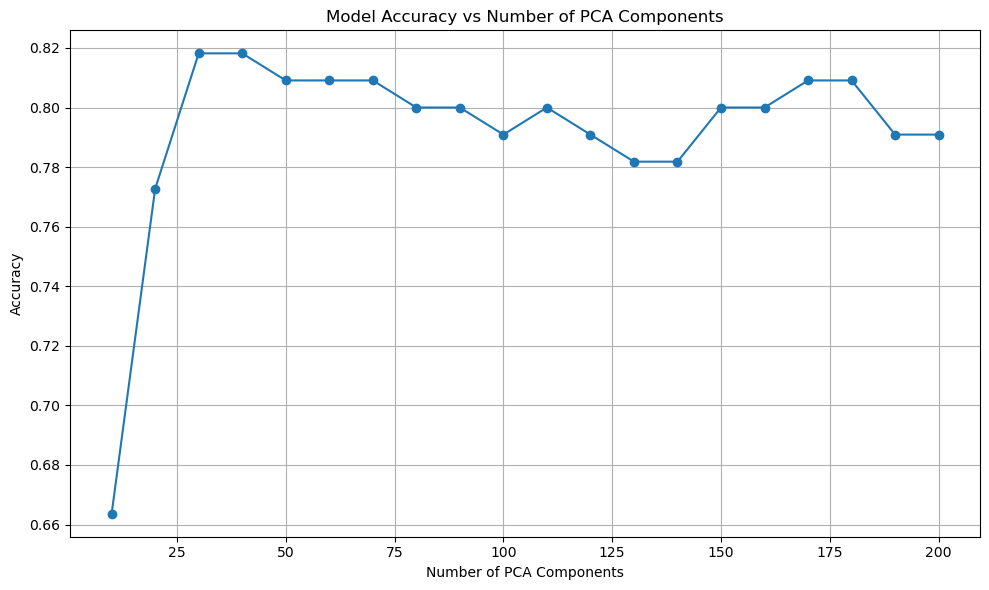

In [64]:
from sklearn.decomposition import PCA

n_components_range = range(10, 201, 10) 
accuracies = []

# loop n
for n in n_components_range:
    # pca with N
    pipe = Pipeline([
        ('pca', PCA(n_components=n)),
        ('svc', SVC(C=100, gamma='scale', kernel='rbf'))
    ])
    
    pipe.fit(X_train, y_train)
    
    acc = pipe.score(X_test, y_test)
    accuracies.append(acc)
    
# best
best_n = n_components_range[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"\nBest accuracy: {best_acc:.4f} with {best_n} PCA components")

# visualize
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, accuracies, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()

The elbow appears to be at 20 components

No improvements from the kaggle code.